## Ultimate goal:

1. Use spikeinterfaces tools to load data (in neuralynx) and run spike sorting
2. After conversion to nwb - run spike sorting on that data

## Status update:

so far not that much progress -- besides complaining to spikeinterfaces ppl.

In [1]:
# Recommended import aliases: https://spikeinterface.readthedocs.io/en/latest/getting_started/plot_getting_started.html
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
# Additional imports
import os.path as op
import neo  # neo for some direct reading to check on # of segments etc

# Sample Neuralynx recording analysis attempt 

## Read the data
Use `neo` directly to get sense of the data and then specific extractor

In [2]:
# sample_file1 is in a folder with .ncs files, sample_file 2 is in a folder with only .ntt files
sample_file1 = 'data/MotivationalT-v2/R050/R050-2014-03-31_raw/R050-2014-03-31-TT04.ntt'
sample_file2 = 'data/MotivationalT-v2/R050/R050-2014-03-31_trial/R050-2014-03-31-TT04.ntt'
dname1 = (op.dirname(sample_file1))
dname2 = (op.dirname(sample_file2))

In [3]:
# To check what's the difference between the two cases
reader1 = neo.NeuralynxIO(dirname=dname1)
reader2 = neo.NeuralynxIO(dirname=dname2)
l1 = dir(reader1)
l2 = dir(reader2)
print (l1)
print (l2)
unique1 = [x for x in l1 if not (x in l2)]
unique2 = [x for x in l2 if not (x in l1)]
print(unique1)
print(unique2)
# Access to protected ._sigs_length doesn't work for Yarik
# print(reader1._sigs_length)
# print(reader1._sigs_memmap)
# print(reader1._sigs_sampling_rate)
# print(reader1._sigs_t_start)
# print(reader1._sigs_t_stop)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_check_common_characteristics', '_empty_ncs', '_empty_nse_ntt', '_event_count', '_generate_minimal_annotations', '_get_analogsignal_chunk', '_get_channel_indexes', '_get_event_timestamps', '_get_signal_size', '_get_signal_t_start', '_get_spike_raw_waveforms', '_get_spike_timestamps', '_group_signal_channel_characteristics', '_make_signal_channel_subgroups', '_nb_segment', '_nev_memmap', '_parse_header', '_prefered_signal_group_mode', '_prefered_units_group_mode', '_raw_annotate', '_repr_annotations', '_rescale_epoch_duration', '_rescale_event_timestamp', '_rescale_spike_timestamp', '_seg_t_starts', '_seg_t_stops', '_segment_t_start', '_

In [4]:
# Seeing the differences between the two objects
print(reader1)
print(reader2)

NeuralynxIO: data/MotivationalT-v2/R050/R050-2014-03-31_raw
nb_block: 1
nb_segment:  [1]
signal_channels: []
unit_channels: [chTT1#64#0, chTT1#65#0, chTT1#66#0, chTT1#67#0 ... chTT16#28#0 chTT16#29#0 chTT16#30#0 chTT16#31#0]
event_channels: []

NeuralynxIO: data/MotivationalT-v2/R050/R050-2014-03-31_trial
nb_block: 1
nb_segment:  [1]
signal_channels: []
unit_channels: [chTT1#64#0, chTT1#65#0, chTT1#66#0, chTT1#67#0 ... chTT16#28#0 chTT16#29#0 chTT16#30#0 chTT16#31#0]
event_channels: []



In [5]:
#  Neo can handle a folder with only ntt files, spikeExtractor cannot
# Passing sample_file 2 will fail
recording0 = se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file1), seg_index=0) # block_index=0, 
recording1 = se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file1), seg_index=1)
recording2 = se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file1), seg_index=2)
recordingList = [recording0, recording1, recording2]
recording_full = se.MultiRecordingTimeExtractor(recordingList)

# recording4 = se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file2), seg_index=0) # Won't work



AssertionError: This file have several channel groups spikeextractors support only one groups

In [14]:
print(se)

<module 'spikeinterface.extractors' from '/home/yoh/anaconda-5.2.0-2.7/envs/mvdm-nept/lib/python3.7/site-packages/spikeinterface/extractors.py'>


In [7]:
# Setting up parameters for Klusta
neuralynx_prms = ss.get_default_params('klusta')
print("Default parameters\n", neuralynx_prms)
# Change parameters to match ntt format
# @Matt, Can you take a look at this and see if it makes sense?
neuralynx_prms['extract_s_before'] = 8
neuralynx_prms['extract_s_after'] = 24
neuralynx_prms['num_starting_clusters'] = 50
neuralynx_prms['n_features_per_channel'] = 8
print("New parameters\n", neuralynx_prms)

Default parameters
 {'adjacency_radius': None, 'threshold_strong_std_factor': 5, 'threshold_weak_std_factor': 2, 'detect_sign': -1, 'extract_s_before': 16, 'extract_s_after': 32, 'n_features_per_channel': 3, 'pca_n_waveforms_max': 10000, 'num_starting_clusters': 50}
New parameters
 {'adjacency_radius': None, 'threshold_strong_std_factor': 5, 'threshold_weak_std_factor': 2, 'detect_sign': -1, 'extract_s_before': 8, 'extract_s_after': 24, 'n_features_per_channel': 8, 'pca_n_waveforms_max': 10000, 'num_starting_clusters': 50}


In [8]:
# Testing if choosing segment makes a difference to the cluster cutting

klusta_out0 = ss.run_klusta(recording0, output_folder="klusta_test/seg0", **neuralynx_prms)
klusta_out1 = ss.run_klusta(recording1, output_folder="klusta_test/seg1", **neuralynx_prms)
klusta_out2 = ss.run_klusta(recording2, output_folder="klusta_test/seg2", **neuralynx_prms)

# You can't pass the MultiRecordingTimeExtractor object to ss.run_klusta, or a list of recordings.
# klusta_out3 = ss.run_klusta(recordingList, output_folder="klusta_test/seg_list", **neuralynx_prms) # Won't work
# klusta_out4 = ss.run_klusta(recording_full, output_folder="klusta_test/seg_full", **neuralynx_prms) # Won't work

# logging output is dumped to terminal where I started ipython notebook
# see https://github.com/SpikeInterface/spikesorters/issues/135 (open)



WARNING! No channel location given. Add dummy location.
RUNNING SHELL SCRIPT: /Users/manishm/Work/vanDerMeerLab/NWB/hackathon/Github/data-formats/klusta_test/seg0/run_klusta.sh
WARNING! No channel location given. Add dummy location.
RUNNING SHELL SCRIPT: /Users/manishm/Work/vanDerMeerLab/NWB/hackathon/Github/data-formats/klusta_test/seg1/run_klusta.sh
WARNING! No channel location given. Add dummy location.
RUNNING SHELL SCRIPT: /Users/manishm/Work/vanDerMeerLab/NWB/hackathon/Github/data-formats/klusta_test/seg2/run_klusta.sh


In [9]:
print('Units found by Klusta case 1:', klusta_out0.get_unit_ids())
print('Units found by Klusta case 2:', klusta_out1.get_unit_ids())
print('Units found by Klusta case 3:', klusta_out2.get_unit_ids())

#The units found and the number of spikes being detected in each case are different. (show in in the console output are different for each case below)

Units found by Klusta case 1: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Units found by Klusta case 2: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Units found by Klusta case 3: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


<H3>Console output for segment 1</H3>

![title](klusta_test/case1.png)

<H3>Console output for segment 2</H3>

![title](klusta_test/case2.png)

<H3>Console output for segment 3</H3>

![title](klusta_test/case3.png)

In [10]:
# Turns out the spike stamps are the same for all the 3 cases. The "segment" part makes a difference only in the csc part.
# A test below to further show this
st0 = recording0.neo_reader.get_spike_timestamps()
st1 = recording1.neo_reader.get_spike_timestamps()
st2 = recording2.neo_reader.get_spike_timestamps()
common_ts = [x for x in st0 if (x in st1) and (x in st2)]
print(len(st0))
print(len(st1))
print(len(st2))
print(len(common_ts))

35753
35753
35753
35753


In [11]:
# Also the MultiRecordingTime extractor loses the neoreader object
l3 = dir(recording_full)
l4 = dir(recording2)
unique3 = [x for x in l3 if not (x in l4)]
unique4 = [x for x in l4 if not (x in l3)]
print(unique3)
print(unique4)


['_channel_ids', '_find_section_for_frame', '_find_section_for_time', '_first_recording', '_num_channels', '_num_frames', '_recordings', '_sampling_frequency', '_start_frames', '_start_times']
['NeoRawIOClass', 'additional_gain', 'block_index', 'extractor_name', 'installed', 'is_writable', 'mode', 'neo_reader', 'seg_index']


<H1>Other Notes</H1>

- ~~The sum of the spikes detected in all the 3 cases is 59034+46571+123416 = 229021, which is greater than 35753 (the total timestamps from the neo reader. The sampling frequency however is incorrectly detected (2000 Hz), which is a necessary parameter for Klusta sort.  Maybe, I am setting up the parameters for klusta incorrectly.~~ 

- UPDATE: The klusta sort is not the correct thing to use in any case because it expects an analog signal (continuously acquired data). It was detecting spikes on the csc files, and not the ntt files in any case.

- Klusta sort writes this recording.dat file in the output folder, that it uses to do spike detection. But it uses recording.get_traces() to do that, which uses the LFP traces. (Look at the links below)
https://github.com/SpikeInterface/spikesorters/blob/38e396bc23e0ca1630a4c4fad36c4fb13853b051/spikesorters/klusta/klusta.py#L80
https://github.com/SpikeInterface/spikeextractors/blob/34aba7ae4dcebf50356ea2158a899295a1f1e10f/spikeextractors/extraction_tools.py#L261

- **TODO:** Figure out a way to run Kilosort  on the ntt files. I suspect that it will be futile because the timestamps of the neorecorder object stay the same, no matter the segment I choose to extract using spikeExtractor. Must convert ntt files into continouosly acquired format.


In [13]:
# phy is recommended for GUI to curate, data should be exported:
# doesn't quite work yet: https://github.com/SpikeInterface/spiketoolkit/issues/342 (fixed)
# pip3 install -U pyqt5
# pip3 install phy --pre
# pip3 install PyQTWebEngine
st.postprocessing.export_to_phy(recording, klusta_out0, output_folder='klusta_test/phy1')
# and also failed to install phy properly: https://github.com/cortex-lab/phy/issues/998 (open)

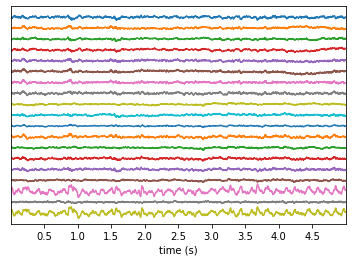

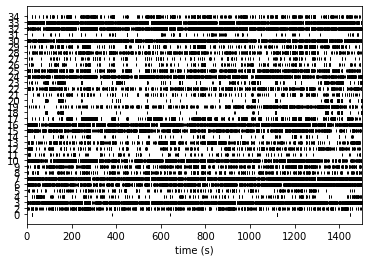

In [14]:
sw.plot_timeseries(recording);
sw.plot_rasters(klusta_out);